### iLQR template code

Author: Muchen Sun

Date: April 30, 2024

*An example of using "solve_bvp" is included in "ME314OptimalControlNotes.pdf* on Canvas.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp

In [2]:
### define parameters

dt = 0.1
# T = 2 * np.pi
x0 = np.array([0.0, 0.0, np.pi/2.0])
tsteps = 63
init_u_traj = np.tile(np.array([1.0, -0.5]), reps=(tsteps,1))

Q_x = np.diag([10.0, 10.0, 2.0])
R_u = np.diag([4.0, 2.0])
P1 = np.diag([20.0, 20.0, 5.0])

Q_z = np.diag([5.0, 5.0, 1.0])
R_v = np.diag([2.0, 1.0])

In [3]:
def dyn(xt, ut):
    # xdot = np.zeros(3)  # replace this
    xdot = np.array([
        np.cos(xt[2]) * ut[0],
        np.sin(xt[2]) * ut[0],
        ut[1]
    ])
    return xdot


def get_A(t, xt, ut):
    # A = np.zeros((3,3))  # replace this
    A = np.array([
        [0.0, 0.0, -np.sin(xt[2]) * ut[0]],
        [0.0, 0.0, np.cos(xt[2]) * ut[0]],
        [0.0, 0.0, 0.0]
    ])
    return A


def get_B(t, xt, ut):
    # B = np.zeros((3,2))  # replace this
    B = np.array([
        [np.cos(xt[2]), 0.0],
        [np.sin(xt[2]), 0.0],
        [0.0, 1.0]
    ])
    return B


def step(xt, ut):
    # xt_new = xt + dt * dyn(xt, ut)  # recommended: replace it with RK4 integration
    k1 = dt * dyn(xt, ut)
    k2 = dt * dyn(xt + k1 / 2.0, ut)
    k3 = dt * dyn(xt + k2 / 2.0, ut)
    k4 = dt * dyn(xt + k3, ut)

    xt_new = xt + 1.0 / 6.0 * (k1 + 2.0 * k2 + 2.0 * k3 + k4)
    return xt_new


def traj_sim(x0, ulist):
    tsteps = ulist.shape[0]
    x_traj = np.zeros((tsteps, 3))
    xt = x0.copy()
    for t in range(tsteps):
        xt_new = step(xt, ulist[t])
        x_traj[t] = xt_new.copy()
        xt = xt_new.copy()
    return x_traj


def loss(t, xt, ut):
    xd = np.array([
        2.0*t / np.pi, 0.0, np.pi/2.0
    ])  # desired system state at time t

    # x_loss = 0.0  # replace this
    # u_loss = 0.0  # replace this
    
    x_loss = (xt - xd).T @ Q_x @ (xt - xd)
    u_loss = ut.T @ R_u @ ut

    return x_loss + u_loss


def dldx(t, xt, ut):
    xd = np.array([
        2.0*t / np.pi, 0.0, np.pi/2.0
    ])

    # dvec = np.zeros(3)  # replace this
    dvec = 2 * Q_x @ (xt - xd)
    return dvec


def dldu(t, xt, ut):
    # dvec = np.zeros(2)  # replace this
    dvec = 2 * R_u @ ut
    return dvec

def x_d(t): 
    return np.array([2.0*t / np.pi, 0.0, np.pi/2.0])

def J(x,u):
    J_ = 0
    for x,u,t in zip(x,u,np.arange(0,2*np.pi,dt)):
        J_ += loss(t,x,u)
    
    xdT = x_d(np.arange(0,2*np.pi,dt)[-1])
    xT = x[-1]
    dxt = xT - xdT
      
    J_ += dxt.T @ P1 @ dxt
    
    return J_


In [4]:
def ilqr_iter(x0, u_traj):
    """
    :param x0: initial state of the system
    :param u_traj: current estimation of the optimal control trajectory
    :return: the descent direction for the control
    """
    # forward simulate the state trajectory
    x_traj = traj_sim(x0, u_traj)

    # compute other variables needed for specifying the dynamics of z(t) and p(t)
    A_list = np.zeros((tsteps, 3, 3))
    B_list = np.zeros((tsteps, 3, 2))
    a_list = np.zeros((tsteps, 3))
    b_list = np.zeros((tsteps, 2))
    # for t_idx in range(tsteps):
    for t_idx,t in enumerate(np.arange(0,2*np.pi,dt)):
        # t = t_idx * dt
        A_list[t_idx] = get_A(t, x_traj[t_idx], u_traj[t_idx])
        B_list[t_idx] = get_B(t, x_traj[t_idx], u_traj[t_idx])
        a_list[t_idx] = dldx(t, x_traj[t_idx], u_traj[t_idx])
        b_list[t_idx] = dldu(t, x_traj[t_idx], u_traj[t_idx])

    # xd_T = np.array([
    #     2.0*(tsteps-1)*dt / np.pi, 0.0, np.pi/2.0
    # ])  # desired terminal state
    xd_T = x_d(np.arange(0,2*np.pi,dt)[-1])
    # p1 = np.zeros(3)  # replace it to be the terminal condition p(T)
    p1 = 2 * P1 @ (x_traj[-1,:] - xd_T)

    def zp_dyn(t, zp):
        t_idx = (t/dt).astype(int)
        At = A_list[t_idx]
        Bt = B_list[t_idx]
        at = a_list[t_idx]
        bt = b_list[t_idx]

        # M_11 = np.zeros((3,3))  # replace this
        M_11 = At
        M_12 = np.zeros((3,3))  # replace this
        M_21 = np.zeros((3,3))  # replace this
        # M_22 = np.zeros((3,3))  # replace this
        M_22 = -At.T
        dyn_mat = np.block([
            [M_11, M_12],
            [M_21, M_22]
        ])

        # m_1 = np.zeros(3)  # replace this
        m_1 = -Bt @ np.linalg.inv(R_v.T) @ (zp[3:].T @ Bt + bt.T) ## CHECK THIS
        # m_2 = np.zeros(3)  # replace this?
        m_2 = -at -zp[:3] @ Q_z ## CHECK THIS
        dyn_vec = np.hstack([m_1, m_2])

        return dyn_mat @ zp + dyn_vec

    # this will be the actual dynamics function you provide to solve_bvp,
    # it takes in a list of time steps and corresponding [z(t), p(t)]
    # and returns a list of [zdot(t), pdot(t)]
    def zp_dyn_list(t_list, zp_list):
        list_len = len(t_list)
        zp_dot_list = np.zeros((6, list_len))
        for _i in range(list_len):
            zp_dot_list[:,_i] = zp_dyn(t_list[_i], zp_list[:,_i])
        return zp_dot_list

    # boundary condition (inputs are [z(0),p(0)] and [z(T),p(T)])
    def zp_bc(zp_0, zp_T):
        # return np.zeros(6)  # replace this
        z0 = zp_0[:3]
        p0 = zp_0[3:]
        zT = zp_T[:3]
        pT = zp_T[3:]
        
        bc = np.zeros(6)
        bc[:3] = z0
        bc[3:] = np.abs(pT - p1)
        
        return bc
    
    

    ### The solver will say it does not converge, but the returned result
    ### is numerically accurate enough for our use
    # zp_traj = np.zeros((tsteps,6))  # replace this by using solve_bvp
    # tlist = np.arange(tsteps) * dt
    tlist = np.arange(0,2*np.pi,dt)
    res = solve_bvp(
        zp_dyn_list, zp_bc, tlist, np.zeros((6,tsteps)),
        max_nodes=100
    )
    zp_traj = res.sol(tlist).T

    z_traj = zp_traj[:,:3]
    p_traj = zp_traj[:,3:]

    v_traj = np.zeros((tsteps, 2))
    for _i in range(tsteps):
        At = A_list[_i]
        Bt = B_list[_i]
        at = a_list[_i]
        bt = b_list[_i]

        zt = z_traj[_i]
        pt = p_traj[_i]

        # vt = np.zeros(2)  # replace this
        vt = -np.linalg.inv(R_v.T) @ (pt.T @ Bt + bt.T)
        
        v_traj[_i] = vt

    return v_traj

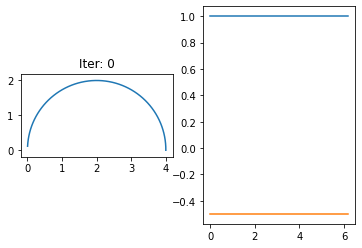

[[ -540.62874238   944.09043069]
 [  944.09043069 -6642.83559669]]
1.0
0.5
0.25


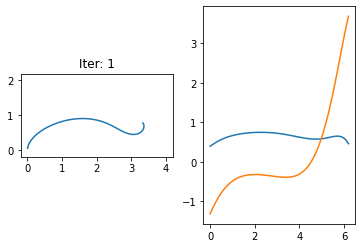

[[-1269.21612989 -1274.41470667]
 [-1274.41470667 -3154.87738041]]
1.0
0.5
0.25


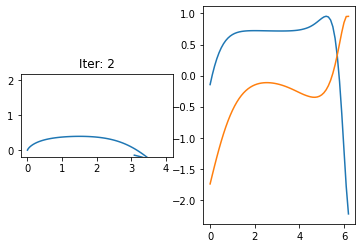

[[-1617.95519199  -932.03052522]
 [ -932.03052522 -1324.66860382]]
1.0
0.5
0.25
0.125


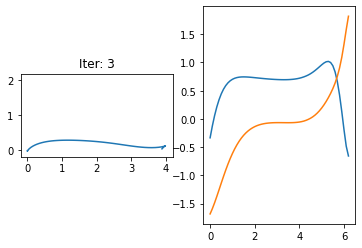

[[-57.10702522  49.12851982]
 [ 49.12851982 -98.38804111]]
1.0
0.5
0.25
0.125


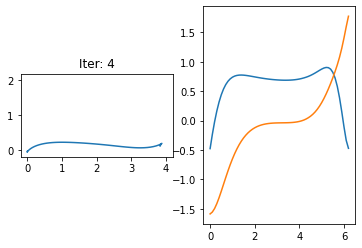

[[-23.56999999  16.76240682]
 [ 16.76240682 -30.03848914]]
1.0
0.5


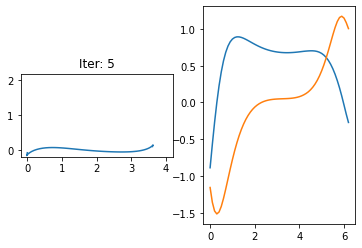

[[ -8.44966696   7.79066214]
 [  7.79066214 -17.47094784]]
1.0
0.5
0.25
0.125
0.0625
0.03125
0.015625
0.0078125
0.00390625
0.001953125
0.0009765625
0.00048828125
0.000244140625
0.0001220703125
6.103515625e-05
3.0517578125e-05
1.52587890625e-05
7.62939453125e-06
3.814697265625e-06
1.9073486328125e-06
9.5367431640625e-07
4.76837158203125e-07
2.384185791015625e-07
1.1920928955078125e-07
5.960464477539063e-08
2.9802322387695312e-08
1.4901161193847656e-08
7.450580596923828e-09
3.725290298461914e-09
1.862645149230957e-09
9.313225746154785e-10
4.656612873077393e-10
2.3283064365386963e-10
1.1641532182693481e-10
5.820766091346741e-11
2.9103830456733704e-11
1.4551915228366852e-11
7.275957614183426e-12
3.637978807091713e-12
1.8189894035458565e-12
9.094947017729282e-13
4.547473508864641e-13
2.2737367544323206e-13
1.1368683772161603e-13
5.684341886080802e-14
2.842170943040401e-14
1.4210854715202004e-14
7.105427357601002e-15
3.552713678800501e-15


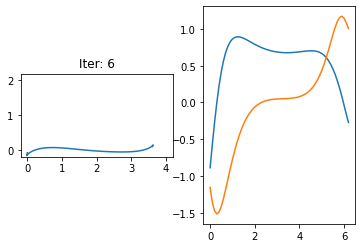

[[ -8.44966696   7.79066209]
 [  7.79066209 -17.47094789]]
1.0
0.5
0.25
0.125
0.0625
0.03125
0.015625
0.0078125
0.00390625
0.001953125
0.0009765625
0.00048828125
0.000244140625
0.0001220703125
6.103515625e-05
3.0517578125e-05
1.52587890625e-05
7.62939453125e-06
3.814697265625e-06
1.9073486328125e-06
9.5367431640625e-07
4.76837158203125e-07
2.384185791015625e-07
1.1920928955078125e-07
5.960464477539063e-08
2.9802322387695312e-08
1.4901161193847656e-08
7.450580596923828e-09
3.725290298461914e-09
1.862645149230957e-09
9.313225746154785e-10
4.656612873077393e-10
2.3283064365386963e-10
1.1641532182693481e-10
5.820766091346741e-11
2.9103830456733704e-11
1.4551915228366852e-11
7.275957614183426e-12
3.637978807091713e-12
1.8189894035458565e-12
9.094947017729282e-13
4.547473508864641e-13
2.2737367544323206e-13
1.1368683772161603e-13
5.684341886080802e-14
2.842170943040401e-14
1.4210854715202004e-14
7.105427357601002e-15


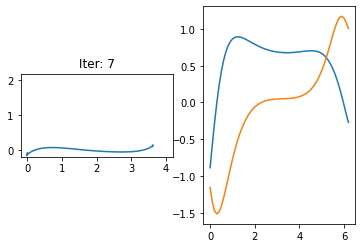

[[ -8.44966734   7.79066211]
 [  7.79066211 -17.47094773]]
1.0
0.5
0.25
0.125
0.0625
0.03125
0.015625
0.0078125
0.00390625
0.001953125
0.0009765625
0.00048828125
0.000244140625
0.0001220703125
6.103515625e-05
3.0517578125e-05
1.52587890625e-05
7.62939453125e-06
3.814697265625e-06
1.9073486328125e-06
9.5367431640625e-07
4.76837158203125e-07
2.384185791015625e-07
1.1920928955078125e-07
5.960464477539063e-08
2.9802322387695312e-08
1.4901161193847656e-08
7.450580596923828e-09
3.725290298461914e-09
1.862645149230957e-09
9.313225746154785e-10
4.656612873077393e-10
2.3283064365386963e-10
1.1641532182693481e-10
5.820766091346741e-11
2.9103830456733704e-11
1.4551915228366852e-11
7.275957614183426e-12
3.637978807091713e-12
1.8189894035458565e-12
9.094947017729282e-13
4.547473508864641e-13
2.2737367544323206e-13
1.1368683772161603e-13
5.684341886080802e-14
2.842170943040401e-14
1.4210854715202004e-14
7.105427357601002e-15
3.552713678800501e-15
1.7763568394002505e-15


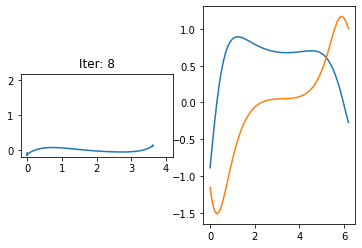

[[ -8.44966727   7.79066212]
 [  7.79066212 -17.47094754]]
1.0
0.5
0.25
0.125
0.0625
0.03125
0.015625
0.0078125
0.00390625
0.001953125
0.0009765625
0.00048828125
0.000244140625
0.0001220703125
6.103515625e-05
3.0517578125e-05
1.52587890625e-05
7.62939453125e-06
3.814697265625e-06
1.9073486328125e-06
9.5367431640625e-07
4.76837158203125e-07
2.384185791015625e-07
1.1920928955078125e-07
5.960464477539063e-08
2.9802322387695312e-08
1.4901161193847656e-08
7.450580596923828e-09
3.725290298461914e-09
1.862645149230957e-09
9.313225746154785e-10
4.656612873077393e-10
2.3283064365386963e-10
1.1641532182693481e-10
5.820766091346741e-11
2.9103830456733704e-11
1.4551915228366852e-11
7.275957614183426e-12
3.637978807091713e-12
1.8189894035458565e-12
9.094947017729282e-13
4.547473508864641e-13
2.2737367544323206e-13
1.1368683772161603e-13
5.684341886080802e-14
2.842170943040401e-14
1.4210854715202004e-14
7.105427357601002e-15
3.552713678800501e-15
1.7763568394002505e-15


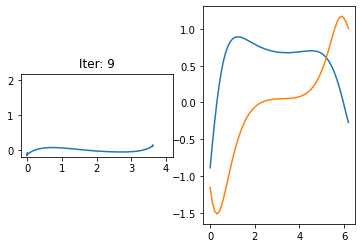

[[ -8.44966726   7.79066203]
 [  7.79066203 -17.47094719]]
1.0
0.5
0.25
0.125
0.0625
0.03125
0.015625
0.0078125
0.00390625
0.001953125
0.0009765625
0.00048828125
0.000244140625
0.0001220703125
6.103515625e-05
3.0517578125e-05
1.52587890625e-05
7.62939453125e-06
3.814697265625e-06
1.9073486328125e-06
9.5367431640625e-07
4.76837158203125e-07
2.384185791015625e-07
1.1920928955078125e-07
5.960464477539063e-08
2.9802322387695312e-08
1.4901161193847656e-08
7.450580596923828e-09
3.725290298461914e-09
1.862645149230957e-09
9.313225746154785e-10
4.656612873077393e-10
2.3283064365386963e-10
1.1641532182693481e-10
5.820766091346741e-11
2.9103830456733704e-11
1.4551915228366852e-11
7.275957614183426e-12
3.637978807091713e-12
1.8189894035458565e-12
9.094947017729282e-13
4.547473508864641e-13
2.2737367544323206e-13
1.1368683772161603e-13
5.684341886080802e-14
2.842170943040401e-14
1.4210854715202004e-14
7.105427357601002e-15
3.552713678800501e-15


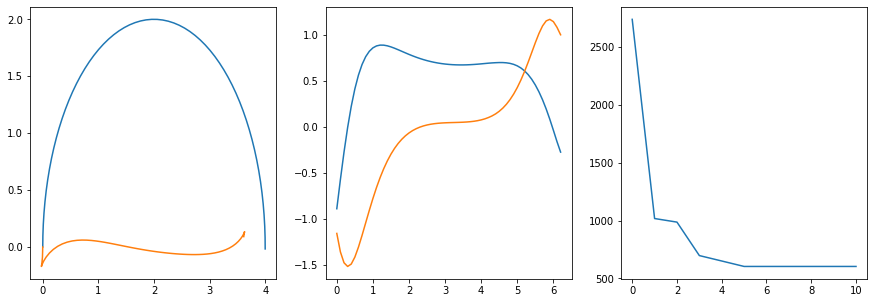

In [6]:
# Start iLQR iterations here

u_traj = init_u_traj.copy()
J_list = np.zeros(11)
J_list[0] = J(traj_sim(x0, u_traj),u_traj)
for iter in range(10):
    # forward simulate the current trajectory
    x_traj = traj_sim(x0, u_traj)

    # visualize the current trajectory
    fig, ax = plt.subplots(1, 2)
    ax[0].set_title('Iter: {:d}'.format(iter))
    ax[0].set_aspect('equal')
    ax[0].set_xlim(-0.2, 4.2)
    ax[0].set_ylim(-0.2, 2.2)
    ax[0].plot(x_traj[:,0], x_traj[:,1], linestyle='-', color='C0')
    
    ax[1].plot(np.arange(0,2*np.pi,dt), u_traj[:,0], linestyle='-', color='C0')
    ax[1].plot(np.arange(0,2*np.pi,dt), u_traj[:,1], linestyle='-', color='C1')
    plt.show()
    plt.close()

    # get descent direction
    v_traj = ilqr_iter(x0, u_traj)

    # Armijo line search parameters
    gamma = 1.0  # initial step size
    alpha = 1e-04
    beta = 0.5

    print(-v_traj.T @ v_traj)
    ### Implement Armijo line search here to update step size gamma
    while J(x_traj,u_traj + gamma*v_traj) > J(x_traj,u_traj) + alpha * gamma * np.abs(np.trace(v_traj.T @ v_traj)):
        # print(gamma)
        gamma *= beta
    # update control for the next iteration
    u_traj += gamma * v_traj
    J_list[iter+1] = J(traj_sim(x0, u_traj),u_traj)

init_x_traj = traj_sim(x0, init_u_traj)

init_x_traj = np.vstack([x0, init_x_traj])
x_traj = np.vstack([x0, x_traj])

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
#set size of figure


ax[0].plot(init_x_traj[:,0], init_x_traj[:,1], linestyle='-', color='C0')
ax[0].plot(x_traj[:,0], x_traj[:,1], linestyle='-', color='C1')
ax[1].plot(np.arange(0,2*np.pi,dt), u_traj[:,0], linestyle='-', color='C0')
ax[1].plot(np.arange(0,2*np.pi,dt), u_traj[:,1], linestyle='-', color='C1')
ax[2].plot(J_list, linestyle='-', color='C0')
plt.show()
plt.close()
    